In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation Analysis

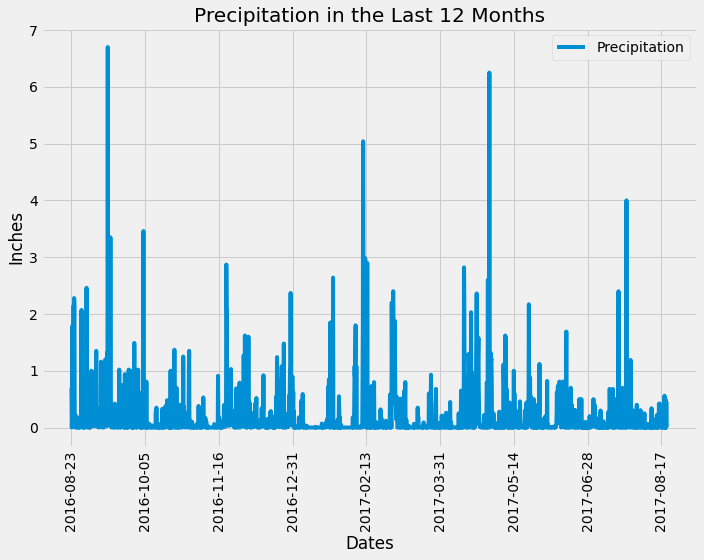

In [10]:
# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

query_month = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_month = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date >= "2016-08-23").\
                    filter(Measurement.prcp.isnot(None)).\
                    order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_month_df = pd.DataFrame(precipitation_month, columns=["date","prcp"]).rename(columns={"prcp":"Precipitation"})
precipitation_month_df.set_index('date', inplace=True)

# Sort the dataframe by date
precipitation_month_graph = precipitation_month_df.sort_index(axis=0, ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_month_graph.plot(figsize=(10,8),title="Precipitation in the Last 12 Months", rot=90)
plt.ylabel("Inches")
plt.xlabel("Dates")
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_month_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [12]:
# Look up the variables in measurement table
measurement_first_row = session.query(Measurement).first()
measurement_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fb9efe9f0f0>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [13]:
# Look up the variables in station table
Station_first_row = session.query(Station).first()
Station_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fb9efe9fd68>,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [15]:
session.query(Station.station).group_by(Station.station).all()

[('USC00511918'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00516128'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519281'),
 ('USC00519397'),
 ('USC00519523')]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Station.station, func.count(Measurement.station)).\
            filter(Station.station == Measurement.station).\
            group_by(Station.station).\
            order_by(func.count(Station.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
most_active_query = session.query(Station.station).filter(Station.station == Measurement.station).\
            group_by(Station.station).\
            order_by(func.count(Station.station).desc()).first()
most_active_query

('USC00519281')

In [18]:
# I didn't want to hard code it, so I used https://www.geeksforgeeks.org/python-convert-tuple-to-float-value/ as reference to set this up
most_active = str(''.join(most_active_query))
most_active

'USC00519281'

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Measurement.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

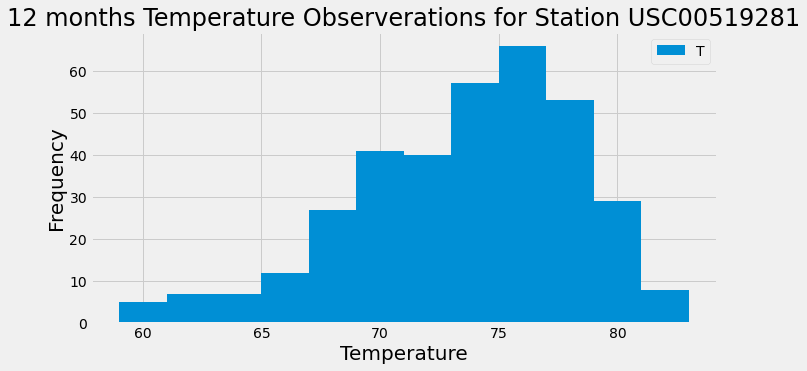

In [20]:
# Choose the station with the highest number of temperature observations.
most_tobs_query = session.query(Measurement.station).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.tobs).desc()).first()

most_tobs = str(''.join(most_tobs_query))

temp_obs = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.station == most_tobs).\
                    filter(Measurement.date >= "2016-08-23").\
                    filter(Measurement.prcp.isnot(None)).\
                    order_by(Measurement.date).all()

temperature_obs = [temp_ob[1] for temp_ob in temp_obs[:]]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
x = temperature_obs 
num_bins = 12


plt.figure(figsize=(10,5))
plt.hist(x, num_bins)
plt.legend("Tobs")

plt.xlabel('Temperature', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.title('12 months Temperature Observerations for Station USC00519281', fontsize=24)
plt.show()

In [21]:
session.close()

## Bonus Challenge Assignment

### Temperature Analysis I

Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

##### Hypothesis:
Hyothesis: If June is warmer than December in Hawaii, then the average daily temperature will be higher.\
Null Hypothesis: If June is not warmer than December in Hawaii, then there will be no difference in the average daily temperature.

In [22]:
#Identify the average temperature in June at all stations across all available years in the dataset. 
#Do the same for December temperature.
june_month_str = "06"
june_temp = session.query(Measurement.tobs).\
            filter(func.strftime("%m", Measurement.date) == june_month_str).all()
dec_month_str = "12"
dec_temp = session.query(Measurement.tobs).\
            filter(func.strftime("%m", Measurement.date) == dec_month_str).all()

In [23]:
np.mean(june_temp)

74.94411764705882

In [24]:
np.mean(dec_temp)

71.04152933421226

In [25]:
# Statistical analysis
from scipy import stats

In [26]:
# From class activity, function created by Instructor Khaled
def pvalue_eval(pval, a=.05):
    if pval<a :
        return f"{pval} ({pval:0.6f}) is Statistically Significant (reject the null hypothesis)"
    return f"{pval} ({pval:0.6f}) is Statistically Non-Significant (failed to reject the null hypothesis)"

In [27]:
#Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
#Will you use a paired t-test, or an unpaired t-test? Why?
results = stats.ttest_ind(june_temp, dec_temp)
results

Ttest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))

In [28]:
pvalue_eval(results[1][0])

'3.9025129038616655e-191 (0.000000) is Statistically Significant (reject the null hypothesis)'

I will use an unpaired t-test, because June and December are two independent groups.

##### Result:
Because our p-value is very small, it indicates that the result was unlikely to have occurred by chance alone; therefore, we can reject the null hypothesis that there is not difference in the average daily temperature between June and December.

### Temperature Analysis II

#### Trip Temperature Analysis

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
min_avg_max = list(np.ravel(calc_temps('2016-10-28', '2016-11-06')))
min_avg_max

[68.0, 75.85714285714286, 79.0]

In [31]:
# Set up codes so I don't need to hard code the values
trip_tmin= min_avg_max[0]
trip_tavg= min_avg_max[1]
trip_tmax= min_avg_max[2]

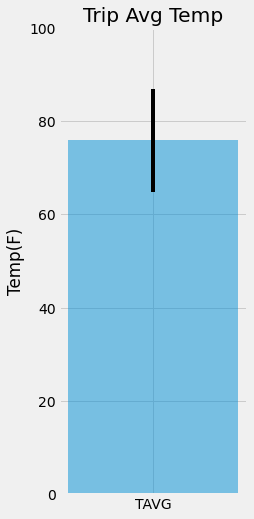

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_axis = ("TAVG")
y_axis = (trip_tavg)
error = trip_tmax-trip_tmin

plt.figure(figsize=(3,8))
plt.bar(x_axis, y_axis, yerr=error, alpha= 0.5)
plt.title("Trip Avg Temp")

plt.ylabel("Temp(F)")
plt.ylim(0, 100)
plt.show()

#### Daily Rainfall Average

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(func.sum(Measurement.prcp), Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation ).\
            filter(Station.station==Measurement.station).\
            filter(Measurement.date >= '2016-10-28').\
            filter(Measurement.date <='2016-11-06').\
            group_by(Station.station).\
            order_by(func.sum(Measurement.prcp).desc()).all()

[(3.5599999999999996,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (0.5200000000000001,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 (0.47000000000000003,
  'USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 (0.27, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (0.23,
  'USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 (0.22, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (None, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
# calculate the daily normals for your trip '2016-10-28'to'2016-11-06'
# push each tuple of calculations into a list called `normals`
normals=[]
# Set the start and end date of the trip
trip_start_date = '2016-10-28'
trip_end_date = '2016-11-06'
# Use the start and end date to create a range of dates 
timestamps = [dt.date(2016, 10, 28), dt.date(2016, 10, 29), 
              dt.date(2016, 10, 30), dt.date(2016, 10, 31),
              dt.date(2016, 11, 1), dt.date(2016, 11, 2),
              dt.date(2016, 11, 3), dt.date(2016, 11, 4),
              dt.date(2016, 11, 5), dt.date(2016, 11, 6)]
# Strip off the year and save a list of %m-%d strings
date_range = [dt.date.strftime(timestamp, '%m-%d') for timestamp in timestamps]
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in date_range:
    normal_loop = list(np.ravel(daily_normals(date)))
    normals.append(normal_loop)
normals

[[68.0, 74.75471698113208, 82.0],
 [68.0, 74.88679245283019, 81.0],
 [64.0, 74.66, 81.0],
 [67.0, 74.83673469387755, 80.0],
 [65.0, 74.86274509803921, 83.0],
 [64.0, 74.0625, 81.0],
 [66.0, 74.95918367346938, 82.0],
 [65.0, 74.0754716981132, 82.0],
 [64.0, 73.5576923076923, 78.0],
 [66.0, 74.31111111111112, 81.0]]

In [36]:
date_range_graph = [dt.date.strftime(timestamp, '%Y-%m-%d') for timestamp in timestamps]

In [37]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame({"TMin":[normal[0] for normal in normals],"TAvg":[normal[1] for normal in normals],
                           "TMax":[normal[2] for normal in normals]})
normals_df["Date"]= date_range_graph
normals_df.set_index("Date", inplace=True)
normals_df

,TMin,TAvg,TMax
Date,,,
2016-10-28,68.0,74.754717,82.0
2016-10-29,68.0,74.886792,81.0
2016-10-30,64.0,74.660000,81.0
2016-10-31,67.0,74.836735,80.0
2016-11-01,65.0,74.862745,83.0
2016-11-02,64.0,74.062500,81.0
2016-11-03,66.0,74.959184,82.0
2016-11-04,65.0,74.075472,82.0
2016-11-05,64.0,73.557692,78.0


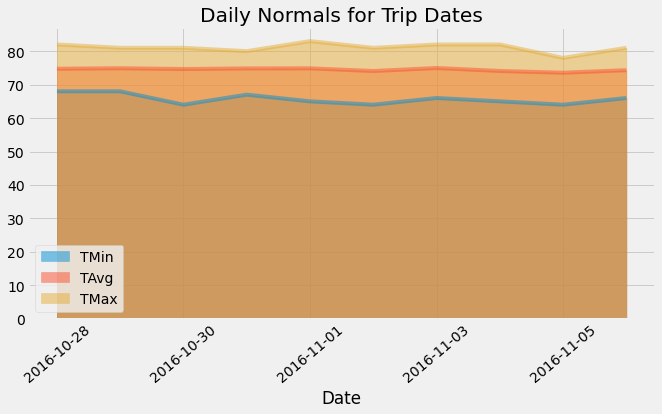

In [38]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, figsize=(10,5), rot=40, title="Daily Normals for Trip Dates")
plt.ylabel=("Temperature")

In [39]:
session.close()